# COMPAS """bedre tittel"""
## Prosjekt 1 i HON2200 - april 2021
### Theodor O. Aaberge, Silje Bentdal, Adrian Ommundsen og Gulla Torvund

## 1."""innledning"""

Planen for oppgaven er som følger. I seksjon [2](#2) (1a og 1b) gjør vi en enkel dataanalyse og sammenlikning av rater for faktisk residivering og predikert residivering innad i forskjellige grupper av befolkningen. I seksjon [3](#3) (1d) studerer vi beslutningene til COMPAS-algoritmen ved å trene en logistisk regresjonsmodell som predikerer COMPAS' avgjørelser på basis av, blant annet, rase og kjønn. Fra vår modell henter vi ut et mål, partial dependence, på hvor mye vekt COMPAS-algoritmen legger på rase-variabelen. I seksjon 4 (1c) diskuterer vi probabilistike mål på grad av diskriminering. I seksjon [4](#4) diskuterer vi funnnene våre og argumenterer for at disse viser at COMPAS-algoritmen diskriminerer på basis av rase. Seksjon 5 konkluderer. 


## 2.  Presentasjon og analyse av data
<a id='2'></a>

*Hvilke data har vi med å gjøre?*
For å forstå dataene, ønsker vi å undersøke spesifikke aspekter ved dem. Vi vil se på relativ frekvens av faktorer innad i de ulike gruppene og sammenligne resultatene. Tilfellene vi skal se på er 
* hvor ofte ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) gjentar forbrytelser og blir predikert å begå straffbare handlinger i framtiden (som andel, ikke totalt antall).

* hvor ofte ulike grupper fikk ulike risikoskårer.

* hvor ofte de som begikk nye straffbare hadlinger (og de som ikke gjorde det) fikk ulike risikoskårer, og hvordan dette ser ut hvis du kun ser på hvite eller svarte.

Først importerer vi nødvendige pakker for hele rapporten. `pandas`brukes i stor grad ettersom vi behandler dataene som "DataFrames".

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import plot_partial_dependence

Vi leser inn dataen. Vi kvitter oss med den dataen hvor siktelsesdatoen er mer enn 30 dager unna datoen for arrestasjonen - ProPublica anså denne dataen som for usikker til å inkludere i studien.

In [44]:
data = pd.read_csv("..//Data/compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]

I denne "første" analysen lager vi en ny `pandas.DataFrame` og inkluderer den dataen som vi ønsker å se nærmere på. Som ProPublica, definerer vi at de som har fått COMPAS-score "Medium" eller "High" predikeres til å residivere innen to år.

In [45]:
df = pd.DataFrame({
    "kvinne": data.sex == "Female",
    "hvit": data.race == "Caucasian",
    "svart": data.race == "African-American",
    "tilbakefall": data.two_year_recid == 1,
    "predikert_tilbakefall": data.score_text != "Low",
    "lav_score": data.score_text == "Low",
    "medium_score": data.score_text == "Medium",
    "høy_score": data.score_text == "High",})

For å regne ut den relative frekvensen av forekomst av en spesifikk egenskap innad i en gruppe, brukes `prosentandel`. Funksjonen `barplott` tar inn de egenskapene og gruppene vi ønsker å undersøke og plotter resultatene i tabell og barplott.

In [46]:
def prosentandel(fokus, gruppe):
    """Regner ut prosentandelen av gruppen (gruppe) som har den spesifikke egenskapen (fokus)
    """
    return float(f'{len(df[fokus & gruppe]) / len(df[gruppe]) * 100:.1f}')

def barplott(fokusliste, gruppeliste, kol_navn, rad_navn, tittel, ha_tabell = 'Ja'):
    """Lager en DataFrame med ønskede prosentandeler og plotter den i et barplott.
    Tar inn lister over egenskaper og grupper man ønsker å undersøke, samt navn som blir synlig i tabell og plott
    OBS! I tabellen er alle tall prosentandeler
    """
    tabell = pd.DataFrame(columns=kol_navn)
    
    for i,fokus in enumerate(fokusliste):
        tabell.loc[i] = [prosentandel(fokus, gruppe) for gruppe in gruppeliste]
    tabell.index = rad_navn
    ax = tabell.plot.bar(colormap='Set3', figsize=(8,6), rot=0)
    ax.set_ylabel('Prosentandel')
    ax.set_title(tittel)
    plt.rcParams.update({'font.size': 13})
    if ha_tabell == 'Ja': # default er å vise tabellen i tillegg til barplottet
        display(tabell)         

Med disse funksjonene kan vi se på den relative forekomsten av .... "endre" får å se på de ulike aspektene:

<a id='21a'></a>
### Hvor ofte gjentar ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) forbrytelser og blir predikert å begå straffbare handlinger i framtiden?

,Kvinner,Menn,Hvite,Svarte
Tilbakefallende,35.1,47.9,39.1,52.3
Predikert tilbakefallende,40.5,45.5,33.1,57.6


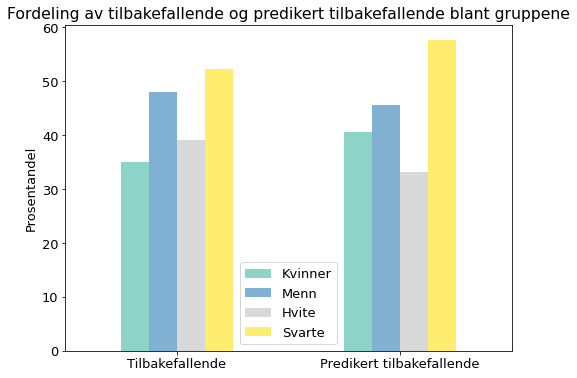

In [47]:
resid_predresid = [df.tilbakefall, df.predikert_tilbakefall]
gruppe = [df.kvinne, ~df.kvinne, df.hvit, df.svart]
gruppenavn = ['Kvinner', 'Menn', 'Hvite', 'Svarte']
resid_predresid_navn = ['Tilbakefallende', 'Predikert tilbakefallende']
tittel1 = 'Fordeling av tilbakefallende og predikert tilbakefallende blant gruppene'
barplott(resid_predresid, gruppe, gruppenavn, resid_predresid_navn, tittel1)

Vi ser at COMPAS-algoritmen predikerer en større andel svarte og kvinner til å residivere enn dét som faktisk er tilfelle, mens den vipper i motsatt retning for menn og hvite. Vi ser også at de ulike gruppene har forskjellige residiveringsrater.

<a id='21b'></a>
### Hvor ofte fikk de ulike gruppene de tre risikoskårene lav, middels og høy?


,Kvinner,Menn,Hvite,Svarte
Lav score,59.5,54.5,66.9,42.4
Middels score,27.7,25.7,22.5,31.0
Høy score,12.9,19.9,10.6,26.6


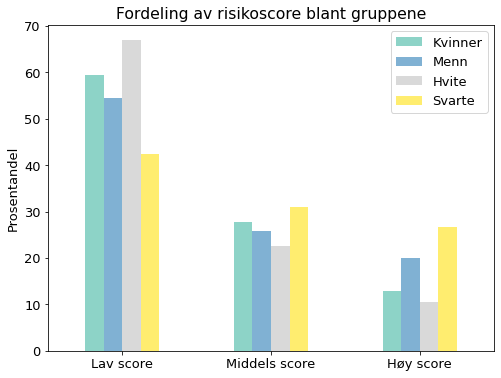

In [60]:
score = [df.lav_score, df.medium_score, df.høy_score]
score_navn = ['Lav score', 'Middels score', 'Høy score']
tittel2 = 'Fordeling av risikoscore blant gruppene'

barplott(score, gruppe, gruppenavn, score_navn, tittel2)

Det mest fremtredende resultatet her er at hvite har tydelig lavere score enn svarte. Hvite har en overveiende prosentandel med lav score, mens de svartes score er mer jevt fordelt.

<a id='21c'></a>
### Hvor ofte fikk tilbakefallende og ikke-tilbakefallende ulike risikoskårer, og hvordan ser dette ut når vi kun ser på hvite og svarte?

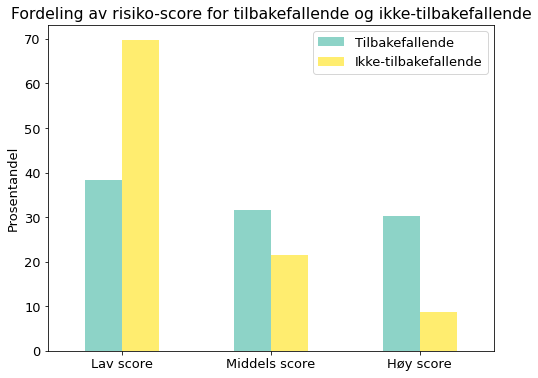

In [63]:
resid = [df.tilbakefall, ~df.tilbakefall]
resid_navn = ['Tilbakefallende', 'Ikke-tilbakefallende']
tittel3 = 'Fordeling av risiko-score for tilbakefallende og ikke-tilbakefallende'

barplott(score, resid, resid_navn, score_navn, tittel3, ha_tabell = 'Nei')

Totalt sett er COMPAS-algoritmen bedre på å predikere de som ikke tilbakefaller enn de som tilbakefaller.
*bør endre noe på denne teksten*

<a id='21d'></a>

,Tilbakefallende hvite,Tilbakefallende svarte,Ikke-tilbakefallende hvite,Ikke-tilbakefallende svarte
Lav score,49.6,28.5,78.0,57.7
Medium score,30.7,33.4,17.3,28.4
Høy score,19.7,38.2,4.8,13.9


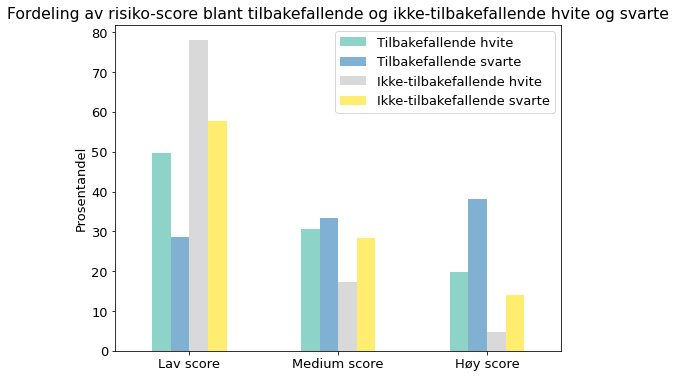

In [65]:
etnisk_resid = [df.hvit & df.tilbakefall, df.svart & df.tilbakefall, df.hvit & ~df.tilbakefall, df.svart & ~df.tilbakefall]
etnisk_resid_navn = ["Tilbakefallende hvite", "Tilbakefallende svarte","Ikke-tilbakefallende hvite","Ikke-tilbakefallende svarte"]
tittel4 = 'Fordeling av risiko-score blant tilbakefallende og ikke-tilbakefallende hvite og svarte'

barplott(score, etnisk_resid, etnisk_resid_navn, score_navn, tittel4)

COMPAS-scoren gjenspeiler ikke-tilbakefallende hvite godt og ikke-tilbakefallende svarte nogenlunde. For tilbakefallende hvite predikerer den omtrent like godt som en random-algoritme.

## Rater og betinget sannsynlighet for undergrupper
<a id='22a'></a>

Vi ønsker nå å se på data for følgende grupper:
* Hele befolkningen
* Kvinner 
* Menn 
* Hvite
* Svarte

Vi undersøker raten av falske positive, sanne positive, falske negative og sanne negative. I tillegg ønsker vi å se på sannsynligheten for at gruppen residiverer (tilbakefall) gitt at de er blitt predikert til å gjøre det, altså COMPAS-algoritmens positiv prediktive verdi.   
Til dette bruker vi funksjonene `falsk_positiv`, `sann_positiv`, `falsk_negativ`, `sann_negativ` og `p_residiv_g_høy`. 

In [51]:
def falsk_positiv(gruppe):
    """Regner ut raten av falske positive for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av falske positive i prosent med én desimal. 
    """
    # FP / (FP + SN)
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & ~df.tilbakefall]) / len(df[gruppe & ~df.tilbakefall]) * 100:.1f}')

def sann_positiv(gruppe):
    """Regner ut raten av sanne positive for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av sanne positive i prosent med én desimal.
    """
    # SP / (SP + FN)
    # sensitivitet
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.tilbakefall]) * 100:.1f}')

def falsk_negativ(gruppe):
    """Regner ut raten av falske negative for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av falske negative i prosent med én desimal.
    """
    # FN / (FN + SP)
    return float(f'{len(df[gruppe & ~df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.tilbakefall]) * 100:.1f}')

def sann_negativ(gruppe):
    """Regner ut raten av sanne negative for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av sanne negative i prosent med én desimal.
    """
    # SN / (SN + FP)
    # spesifisitet
    return float(f'{len(df[gruppe & ~df.predikert_tilbakefall & ~df.tilbakefall]) / len(df[gruppe & ~df.tilbakefall]) * 100:.1f}')

def p_residiv_g_høy(gruppe):
    """Regner ut sannsynligheten for at en gruppe residiverer gitt at de har blitt predikert til å gjøre det
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: sannsynlighet i prosent med én desimal.
    """
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.predikert_tilbakefall]) * 100:.1f}')

In [52]:
alle = np.full(len(df), True)

In [53]:
functions = [falsk_positiv, falsk_negativ, sann_positiv, sann_negativ, p_residiv_g_høy]
grouplist = [alle, df.kvinne, ~df.kvinne, df.hvit, df.svart]
namelist = ['Alle', 'Kvinner', 'Menn', 'Hvite', 'Svarte']
d = {}
for name, group in zip(namelist, grouplist):
    inner_dict = {}
    for function in functions:
        inner_dict[function.__name__] = function(group)
    d[name] = inner_dict
d

{'Alle': {'falsk_positiv': 30.3,
  'falsk_negativ': 38.3,
  'sann_positiv': 61.7,
  'sann_negativ': 69.7,
  'p_residiv_g_høy': 63.0},
 'Kvinner': {'falsk_positiv': 30.2,
  'falsk_negativ': 40.4,
  'sann_positiv': 59.6,
  'sann_negativ': 69.8,
  'p_residiv_g_høy': 51.7},
 'Menn': {'falsk_positiv': 30.3,
  'falsk_negativ': 37.9,
  'sann_positiv': 62.1,
  'sann_negativ': 69.7,
  'p_residiv_g_høy': 65.4},
 'Hvite': {'falsk_positiv': 22.0,
  'falsk_negativ': 49.6,
  'sann_positiv': 50.4,
  'sann_negativ': 78.0,
  'p_residiv_g_høy': 59.5},
 'Svarte': {'falsk_positiv': 42.3,
  'falsk_negativ': 28.5,
  'sann_positiv': 71.5,
  'sann_negativ': 57.7,
  'p_residiv_g_høy': 65.0}}

Spesifisiteten (sanne negative) sier oss noe om hvor bra COMPAS klarer å identifisere personer som ikke kommer til å få tilbakefall. Sensitiviteten (sanne positive) sier noe om hvor bra COMPAS klarer å identifisere personer som kommer til å residivere. Det er først når begge disse tallene er høye det kan konkluderes med at algoritmen er god. Dersom det ene tallet er relativt høyt, imens det andre er relativt lavt, så sier dette noe om algoritmen er strengere i den ene eller andre retningen. For eksempel har vi for hvite at COMPAS har høy sann negativ rate og lav sann positiv rate. Ut ifra dette kan vi trekke frem en hypotese om at den generelt gir lav score for hvite.

Falske positive er personer som ikke residiverer, men som COMPAS predikerer at vil gjøre det. Dette vil være mennesker som får strengere straff enn fortjent. Raten av falske positive vil være viktig å holde lav for individualistiske samfunn.   
Falske negative er personer vi kanskje slipper ut i samfunnet igjen, men som likevel begår en kriminell handling. Disse menneskene vil utgjøre en fare for samfunnet. Raten av falske negative vil være viktig å holde lav for kollektivistiske samfunn. 

Positiv prediktiv verdi sier noe om hvor sannsynlig det er at gruppen residiverer gitt at de blir predikert til å gjøre det. Denne er relativt lav, men høyere enn 50%, for alle grupper (se [plott](#21d)). *siste kommentar kan endres*

## 3.   Modellering av skjevheter i COMPAS på bakgrunn av rase
<a id='3'></a>

Vi undersøker så skjevheter i COMPAS på bakgrunn av rase ved å kontrollere for kjønn, alder, kriminell historie og eventuell gjentatt forbrytelse. Her gjør vi hovedsaklig det samme som ProPublica-studien: vi trener en algoritme på en del av dataen vi har, bruker denne modellen til å predikere den resterende testdataen og sjekker egenskapene til modellen. Vi trener altså modellen vår til å predikere COMPAS-prediksjonen av tilbakefall. Vi bruker `sklearn`-biblioteket og dens `LogisticRegression` for å trene modellen vår. Grunnen til at vi bruker logistisk regresjon er at denne metoden fungerer godt på klassifikasjon med binært utfall.

In [110]:
# velger hensiktsmessig data (samma som ProPublica)
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]

# lager dummies (0 eller 1) av featuresene som er strings
categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')

# tar bort overflødige dummies
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)

# 'fasiten' vår er COMPAS sin prediksjon av tilbakefall (score = (Medium or High))
Y = data["score_text"] != "Low"

# splitter treningsdata og testdata med sklearn sin 'train_test_split', standard test size
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [111]:
# lager modellen vår, som er sklearn sin 'LogisticRegression'
model = LogisticRegression(random_state=0, max_iter=10000)

# trener modellen (tilpasser vekter) og bias på treningsdataen
model.fit(X_train, Y_train)

# tester modellen på testdataen og ser hvor godt modellen gjøre det
Y_mdl = model.predict(X_test)
print(f'Nøyaktigheten til modellen er {accuracy_score(Y_mdl, Y_test):.3f}.')

Nøyaktigheten til modellen er 0.773.


Nå sjekker vi hvor mye vekt som legges på etnisitet når vi korrigerer for andre features. For å finne dette, skaper vi en "standard" person (hvit mann) hvor ingen features vektlegges, og kun biasen sendes inn i sigmoid-funksjonen (aktiveringsfunksjonen i logistisk regresjon). Deretter sammenlikner vi denne nøytrale personen mot en person som kun har egenskapen 'race_African-American = True'. *hvorfor funker dette egt?*

In [112]:
# trenger en sigmoid-funksjon for å skape en "nøytral" person (se neste celle)
def sigmoid(z):
    """klassisk sigmoid-funksjon som tar inn et tall z og returnerer (1/(1+e^-z)) = (e^z/(1+e^z))
    """
    return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z))) #np.where tar høyde for overflow

In [119]:
# lager en nøytral person ved å kun sende biasen inn i sigmoidfunksjonen 
kontroll = sigmoid(model.intercept_)
vekter = model.coef_[0]
# vekter[4] er vekten til race_African-American 
er_svart = vekter[4]
# finner racialBias, bias mht rase, i modellen vår
racialBias = np.exp(er_svart) / (1 - kontroll  + (kontroll * np.exp(er_svart)))
print(f'Bias mot svarte menn relativt til "standardpersonen", altså hvite menn, er {np.mean(racialBias):.3f}.')

Bias mot svarte menn relativt til "standardpersonen", altså hvite menn, er 1.468.


In [120]:
display(X)

,priors_count,two_year_recid,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Hispanic,race_Native American,race_Other,sex_Female,c_charge_degree_M
0,0,0,1,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,0
2,4,1,0,1,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,1
6,14,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7209,0,0,0,1,1,0,0,0,0,0,0
7210,0,0,0,1,1,0,0,0,0,0,0
7211,0,0,1,0,0,0,0,0,1,0,0
7212,3,0,0,0,1,0,0,0,0,1,1


In [118]:
print(vekter)
print(sigmoid(er_svart))
print(er_svart)
print(model.intercept_)
print(sigmoid(model.intercept_))
print((1-sigmoid(er_svart))/(1-sigmoid(model.intercept_)))

[ 0.26664064  0.62701035 -1.26551883  1.24598618  0.49327693 -0.41826474
 -0.37642588  0.95239481 -0.64105123  0.22618849 -0.31743323]
0.6208780882531956
0.49327692721204014
[-1.50741749]
[0.18132184]
[0.46309029]


Altså er modellen vår rundt 45% (endres noe for hver nye modell) mer sannsynlig å predikere svarte til å residivere enn hvite.

Vi ser på hvilken innflytelse de andre parametrene har på utfallet av modellen: 

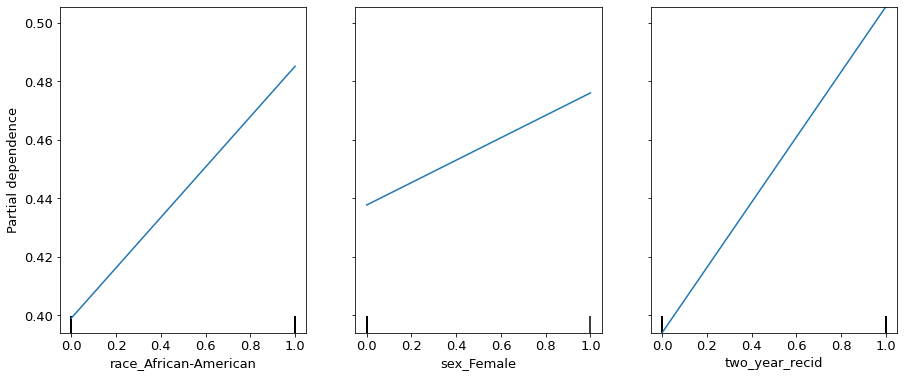

In [126]:
#plotter partial dependance
#her bør det undersøkes mye mer
features = ["race_African-American","sex_Female","two_year_recid"]
plot_partial_dependence(model, X_train, features)
plt.gcf().set_size_inches(15, 6)

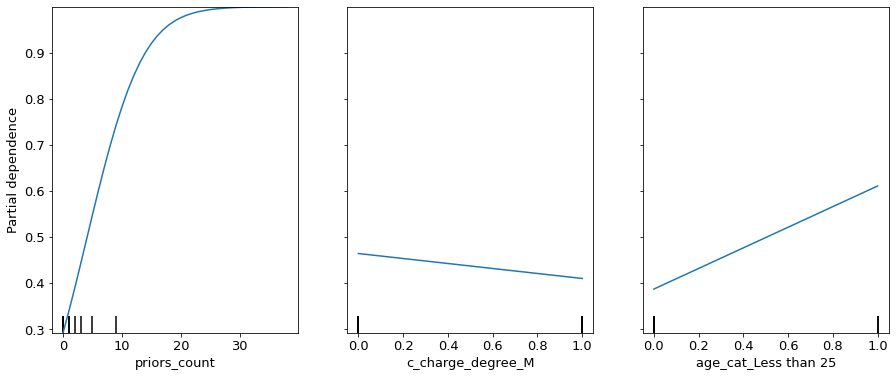

In [128]:
features = ["priors_count", "c_charge_degree_M", 'age_cat_Less than 25']
plot_partial_dependence(model, X_train, features)
plt.gcf().set_size_inches(15, 6)

*kommentar på plottene*

## 4. Probabilistike mål på diskriminering
<a id='4'></a>

*liten intro*

1(c): Betingede sannsynligheter og diskriminering

Vi bruker de følgende forkortelser for hendelser:

$R \sim \text{'Individet residiverer'}$

$C \sim \text{'Individet har prediksjon HIGH av COMPAS'}$

$A \sim \text{'Individet er etnisk afroamerikaner'}$

$E \sim \text{'Individet er etnisk europeisk eller nord-afrikansk/"caucasian"'}$

Når $A$ og $B$ er hendelser lar vi $\neg A$, $A\wedge B$ og $A \vee B$ stå for henholdvis komplementhendelsen til $A$, unionhendelsen av $A$ og $B$ og disjunksjonhendelsen av $A$ og $B$. Sannsynligheten til en hendelse $A$ betegnes $P(A)$; den betingede sannsynligheten av en hendelse $A$ gitt en hendelse $B$ betegnes P(A\mid B)

Ett mulig mål på diskriminering av etnisk afro-amerikanere relativt til etnisk europeere, som foreslått av Henrik, er forholdstallet:

$$D(A;E):=\dfrac{P(C \mid \neg R \wedge A)}{P(C \mid \neg R \wedge E)},$$

som er definert så lenge $P(C \mid \neg R \wedge E)\not=0$. Idéen bak dette målet er å sammenlikne sannsynlighetene for en predikert høy risiko av COMPAS blant etnisk afro-amerikanere som faktisk ikke residiverer og blant etnisk europeere som faktisk ikke residiverer. Jo høyere forholdet mellom disse to sannsynlighetene er, jo mer diskrimineres det mot etnisk afro-amerikanere relativt til etnisk europeere; dette sier hvertfall målet vårt over. 

Vi kan bruke Bayes teorem til å se en relasjon mellom dette målet på diskriminasjon og presisjonen til algoritmen innad i de to gruppene. Teller og nevner er proporsjonale med unøyaktigheten (mangel på spesifisitet) til algoritmen for henholdsvis etnisk afro-amerikanske og etnisk europeiske. Vi ser spesielt på telleren:

$$P(C \mid \neg R \wedge A)=P(\neg R \mid C \wedge A)\cdot\dfrac{P(C\mid A)}{P(\neg R \mid A)}$$

Altså, blandt afro-amerikanske, holder vi fast antall som COMPAS predikerer å ha høy risiko og antall som residiverer, er dette uttrykket bestemt av $P(\neg R\mid C \wedge A)=1-P(R\mid C \wedge A)$. 

Målet vi har over er sannsynligvis ikke et godt mål på diskriminasjon i prediksjoner. Her er en intuitiv forklaring på hvorfor: Dersom én gruppe har høyere sannsynlighet for å residivere enn en annen, så kan uten å diskriminere predikere at den ene gruppen residiverer oftere enn den andre gruppen. Men selv om raten av falske positive blant positive prediskjoner er den samme i begge tilfeller, vil man kunne ha høyere sannsynlighet for falske positive i den ene mer residiverende gruppen enn den andre. Målet over dømmer dermed en slik algoritme for diskriminerende selv om algoritmen intuitivt ikke er diskriminerende. 

Et konkret eksempel er som følger. Vi har en populasjon med 2000 individer hvor vi har to grupper $E$ og $A$ hvor residivering og prediksjonene er som følger: 

 $Totalt$; $R$;  $C$; $C\wedge R$        
 
 $E:$           $1000$;    $500;$       $500;$ $250$
 
 $A:$           $1000;$    $250;$     $250;$          $125$

Denne (unøyaktige) prediksjonsalgoritmen kan man argumentere for at ikke er diskriminerende: den predikerer en persons risiko på bakgrunn av residiveringsraten for den personens etniske gruppe; ingen av gruppene har urettferdig høy unøyaktighet i prediksjonene. (Om du ikke ønsker å predikere ved hjelp av etnisk gruppe kan du omformulere eksempelet slik at prediksjonen blir gjort utelukkende på bakgrunn av en annen variabel, her f. eks. fattigdom, som korrelerer med den ene etnisitetsvariabelen.)

Men målet over sier dette er en svært diskriminerende prediksjon:

$$P(C \mid \neg R \wedge E)=\frac{125}{750}=\frac{5}{30}$$
$$P(C \mid \neg R \wedge A)=\frac{250}{500}=\frac{1}{2}$$

Ifølge målet over diskriminerer derfor prediksjonen sterkt imot $E$ relativt til $A$, selv om dette intuitivt ikke er riktig: gruppen $E$ har mye høyere residiveringsrate, som er grunnen til at det predikeres oftere at individer av gruppen $E$ vil residivere, som er grunnen til at flere ikke-residiverende $E$-er får en falsk positiv prediksjon.

Et par mål som ikke lider av dette problemet er de følgende. Først, et mål på forskjell i rate av falske positive: 

$$D_+(A;E):=\dfrac{P(\neg R \mid C \wedge A)}{P(\neg R \mid C \wedge E)},$$

Annet, et mål på forskjell i rate av falske negative: 
$$D_-(A;E):=\dfrac{P( R \mid \neg C \wedge A)}{P( R \mid \neg C \wedge E)}.$$

Merk at disse målene er uavhengige av hverandre: en gruppe som har høyere (lavere) falsk positiv rate enn en annen gruppe kan ha høyere og kan ha lavere falsk negativ rate enn den andre gruppen. 

Ett mulig krav på at en algoritme skal være ikke-diskriminerende kan være at den har ingen eller lav grad av både falsk positiv og falsk negativ diskriminering. I dette tilfellet kommer dette kravet til at (når de kondisjonelle sannsynlighetene er definerte):

$$P(\neg R \mid C \wedge A)=P(\neg R \mid C \wedge E)\text{, og}$$

$$P( R \mid \neg C \wedge A)=P( R \mid \neg C \wedge E).$$

La oss se at disse målene ikke lider av problemet vi hadde med det forrige målet. Ta eksempelet vi brukte med populasjonen av 2000 over. Da har vi at prediksjonen ikke er diskriminerende, altså den tilfredstiller betingelsene over. For eksempel, i tilfellet for rate av falsk positiv har vi ingen forskjell, altså ingen diskriminering:

$$P(\neg R \mid C \wedge A)=\dfrac{125}{250}=\dfrac{1}{2}=\dfrac{250}{500}=P( \neg R \mid C \wedge E).$$

## 5. Diskusjon

- Rar observasjon: kvinner predikeres til å ha høyere residiveringsrate enn de faktisk har. Dette er ikke den biasen man vil forvente av en menneskelig dommer. 

Merknad til diskusjon: modellen vår har en accuracy på 75% - altså langt fra hva man vanligvis kaller en god modell. Derfor kan vi ikke bastant anklage COMPAS til å være "så-og-så mange prosent rasistisk", ettersom vår modell ikke er helt lik COMPAS sin modell. Vi kan anklage den for å være diskriminerende, men kvier oss for å bruke tall fra oppgave 1d. Derfor er det bedre å bruke tall fra oppgave 1a og 1b over som er ren analyse av dataen.